# **Lý Phi Long - 1611146**

In [1]:
## import các module cần thiết
import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, Dense, Flatten, Input, Reshape, Dropout, ReLU, Conv2DTranspose, BatchNormalization, LeakyReLU, Concatenate, Activation, UpSampling2D, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras import layers

In [0]:
## import các module cần thiết
import tensorflow as tf
from tensorflow.keras.layers import Convolution2D, Dense, Flatten, Input, Reshape, Dropout, ReLU, Conv2DTranspose, BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras import layers


## Xây dựng cấu trúc cho discriminator
def get_discriminator():
    """
    Input: ảnh (28, 28), các phần tử trong ảnh thuộc  [-1,1]
    Output: số thực trong đoạn [0,1], càng gần 1 thì ảnh input càng là ảnh thật không phải do generator tạo ra
    """
    input_layer = Input(shape=(28,28))
    condition_layer = Input(shape=(10,))
    
    xx = Reshape((28,28,1))(input_layer)
    xx = Convolution2D(filters=64,
                       kernel_size=[5,5],
                       strides=[2,2],
                       padding='same')(xx)
    xx = LeakyReLU(0.2)(xx)

    xx = Convolution2D(filters=128,
                       kernel_size=[5,5],
                       strides=[2,2],
                       padding='same')(xx)
    xx = LeakyReLU(0.2)(xx)

    xx = Flatten()(xx)
    
    mere_input = Concatenate()([xx, condition_layer])
    outputs = Dense(units=1, activation='sigmoid')(mere_input)

    model = Model(inputs=[input_layer,condition_layer], outputs=outputs)

    return model

## Xây dựng cấu trúc cho generator
def get_generator():
    """
    Input: vector (100,) 
    Output: ảnh (28,28) được tạo từ vector input
    """
    input_layer = Input(shape=(100,))
    
    
    condition_layer = Input(shape=(10,))
    
    mere_input = Concatenate()([input_layer, condition_layer])
    
    xx = Dense(units=7*7*256,
               use_bias=False)(mere_input)
    
    xx = Reshape((7,7,256))(xx)
    xx = BatchNormalization()(xx)
    xx = LeakyReLU(0.2)(xx)
    
    
    xx = Convolution2D(filters=128, kernel_size=4, strides=1,padding='same')(xx)
    xx = BatchNormalization()(xx)    
    xx = LeakyReLU(alpha=0.2)(xx)
    
    
    xx = Conv2DTranspose(filters=512,
                         kernel_size=[5,5],
                         strides=[2,2],
                         padding='same',
                         use_bias=False)(xx)
    xx = BatchNormalization()(xx)
    xx = LeakyReLU(0.2)(xx)

    xx = Conv2DTranspose(filters=64,
                         kernel_size=[5,5],
                         strides=[2,2],
                         padding='same',
                         use_bias=False)(xx)
    xx = BatchNormalization()(xx)
    xx = LeakyReLU(0.2)(xx)

    
    xx = Conv2DTranspose(filters=1,
                         kernel_size=[5,5],
                         strides=[2,2],
                         padding='same',
                         use_bias=False,
                         activation='tanh')(xx)   ## hàm kích hoạt lớp cuối cùng là tanh, giá trị điểm ảnh thuộc [-1, 1]

    outputs=Reshape((28,28))(xx)

    model = Model(inputs=[input_layer, condition_layer], outputs=outputs)

    return model

In [0]:
def get_generator():
  '''
  Input: là 1 vector nhiễu (100,0)
         là 1 vector label (100,0)
  Output: là một ảnh (28x28x1) 
  '''
  input_z = Input((100,))
  dense_z_1 = Dense(1024)(input_z)
  act_z_1 = Activation("tanh")(dense_z_1)
  dense_z_2 = Dense(128 * 7 * 7)(act_z_1)
  bn_z_1 = BatchNormalization()(dense_z_2)
  reshape_z = Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_z_1)
  
  
  input_c = Input((100,))
  dense_c_1 = Dense(1024)(input_c)
  act_c_1 = Activation("tanh")(dense_c_1)
  dense_c_2 = Dense(128 * 7 * 7)(act_c_1)
  bn_c_1 = BatchNormalization()(dense_c_2)
  reshape_c = Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_c_1)
  
  concat_z_c = Concatenate()([reshape_z, reshape_c])
  
  up_1 = UpSampling2D(size=(2, 2))(concat_z_c)
  conv_1 = Convolution2D(filters = 64, 
                  kernel_size = (5, 5), 
                  padding='same')(up_1)
  act_1 = LeakyReLU(0.2)(conv_1)
  
  up_2 = UpSampling2D(size=(2, 2))(act_1)
  conv_2 = Convolution2D(filters=1, 
                  kernel_size= (5, 5), 
                  padding='same')(up_2)
  act_2 = LeakyReLU(0.2)(conv_2)
  
  
  model = Model(inputs=[input_z, input_c], outputs=act_2)

  return model



def get_discriminator ():
  '''
  Input: 1 ảnh (28,28,1) và 1 vector label one-hot-encoder (100,0) 
  Output: ảnh thật hay ảnh fake
  '''
  input_gen_image = Input((28, 28, 1))
  
  #Vì ảnh input và vector label có kích thược khác nhau nên ta không concate được nên ta cần tiền xử lý trước.
  
  conv_1_image = Convolution2D(64, (5, 5), padding='same')(input_gen_image)
  act_1_image = Activation("tanh")(conv_1_image)
  pool_1_image = MaxPooling2D(pool_size=(2, 2))(act_1_image)
  conv_2_image = Convolution2D(128, (5, 5))(pool_1_image)
  act_2_image = Activation("tanh")(conv_2_image)
  pool_2_image = MaxPooling2D(pool_size=(2, 2))(act_2_image)
  
  
  input_c = Input((100,))
  dense_1_c = Dense(1024)(input_c)
  act_1_c = Activation("tanh")(dense_1_c)
  dense_2_c = Dense(5 * 5 * 128)(act_1_c)
  bn_c = BatchNormalization()(dense_2_c)
  reshaped_c = Reshape((5, 5, 128))(bn_c)
  
  concat = Concatenate()([pool_2_image, reshaped_c]) #concate ảnh của generator và label
  flat = Flatten()(concat)
  dense_1 = Dense(1024)(flat)
  act_1 = Activation("tanh")(dense_1)
  dense_2 = Dense(1)(act_1)
  act_2 = Activation('sigmoid')(dense_2)
  
  model = Model(inputs=[input_gen_image, input_c], outputs=act_2)

  return model

In [0]:
def get_generator_training(discriminator, generator):
  [input_layer, condition_layer] = generator.inputs
  outputs = discriminator([generator.outputs, condition_layer])
  model = Model(inputs=[input_layer, condition_layer], outputs=outputs)
   
  generator.trainable = True
  discriminator.trainable = False

  # compile
  model.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
                  loss=tf.keras.losses.binary_crossentropy,
                  metrics=['accuracy'])
    
  return model

def get_discriminator_training(discriminator):
    """
    Input: discriminator
    Output: một model, thiết lập sẵn quá trình huấn luyện cho discriminator
    """

    ## model này có input y chang discriminator
    [input_layer, condition_layer] = discriminator.inputs
    outputs = discriminator.outputs
    model = Model(inputs=[input_layer, condition_layer], outputs=outputs)  

    ## discriminator được huấn luyện
    discriminator.trainable = True

    ## compile
    model.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
                  loss=tf.keras.losses.binary_crossentropy,
                  metrics=['accuracy'])
    return model

In [5]:
## tạo các object
generator = get_generator()
discriminator = get_discriminator()
generator_train = get_generator_training(discriminator, generator)
discriminator_train = get_discriminator_training(discriminator)

generator.summary()
discriminator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_4:0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         103424      input_1[0][0]           

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = (X_train-127.5)/127.5, (X_test-127.5)/127.5

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
from keras import utils as keras_utils
X_train = X_train[:, :, :, None]
y_train = keras_utils.to_categorical(y_train, 100)

Using TensorFlow backend.


In [0]:
def generate_condition_embedding(label: int, nb_of_label_embeddings: int):
    label_embeddings = np.zeros((nb_of_label_embeddings, 100))
    label_embeddings[:, label] = 1
    return label_embeddings

In [0]:
def generate_noise(shape: tuple):
    noise = np.random.uniform(0, 1, size=shape)
    return noise

In [10]:
import numpy as np
### Huấn luyện
batch_size = 200

## thiết lập các labels sẵn
y_ones = np.ones((batch_size,))
y_zeros = np.zeros((batch_size,))
y_train_batch = np.concatenate([0.9*y_ones, y_zeros], axis=0)
y_eval_zeros = np.zeros((10000,1))

for epoch in range(40):
  #  np.random.shuffle(X_train)    ## xáo vi vị trí các ảnh trong tập train

    for i_batch in range(0,60000,batch_size):
        ## huấn luyện discriminator

        X_real_batch = X_train[i_batch:i_batch+batch_size]  ## lấy một batch ảnh thật
        y_real_batch = y_train[i_batch:i_batch+batch_size]  ## lấy một batch các label của ảnh

        random_noise_batch = np.random.normal(0.0, 1.0, size=[batch_size,100]) ## tạo một batch vector ngẫu nhiên
        
       
        
        
        X_fake_batch = generator.predict([random_noise_batch,y_real_batch])                    ## tạo một batch các ảnh giả từ generator

        y = [1] * batch_size + [0] * batch_size
        
        X_train_batch = np.concatenate([X_real_batch, X_fake_batch])    ## nối ảnh thật và ảnh giả
        y_train_batch = np.concatenate((y_real_batch, y_real_batch))    
        
        
        
        discriminator_train.train_on_batch([X_train_batch, y_train_batch],y)        ## huấn luyện discriminator với label của ảnh thật là 1.0, label của ảnh giả là 0.0

        ## huấn luyện generator
        random_noise_batch = np.random.normal(0.0, 1.0, size=[batch_size,100])  ## tạo một batch vector ngẫu nhiên
        generator_train.train_on_batch([random_noise_batch,y_real_batch], [1] * batch_size)            ## huấn luyện generator, với label toàn là 1.0 (để lừa discriminator rằng ảnh giả này là ảnh thật)
    
    
    ##xem accuracy của discriminator với ảnh giả là bao nhiêu
    ##random_noise = np.random.normal(0.0, 1.0, size=[10,100])
    
   # '''
    nb_of_images=10000
    label_to_generate=6
    random_noise = generate_noise((nb_of_images, 100))
    random_label = generate_condition_embedding(label_to_generate, nb_of_images)
    _, train_acc = generator_train.evaluate([random_noise,random_label],y_eval_zeros)

    print("Epoch {} - Discriminator accuracy on fake images {}".format(epoch+1, train_acc ))
 #   '''
   


10000/10000 [==============================] - 1s 133us/sample - loss: 4.8693 - acc: 0.0000e+00
Epoch 1 - Discriminator accuracy on fake images 0.0
10000/10000 [==============================] - 1s 125us/sample - loss: 0.4407 - acc: 1.0000
Epoch 2 - Discriminator accuracy on fake images 1.0
10000/10000 [==============================] - 1s 118us/sample - loss: 0.3055 - acc: 1.0000
Epoch 3 - Discriminator accuracy on fake images 1.0
10000/10000 [==============================] - 1s 122us/sample - loss: 0.0322 - acc: 1.0000
Epoch 4 - Discriminator accuracy on fake images 1.0
10000/10000 [==============================] - 1s 121us/sample - loss: 0.2150 - acc: 1.0000
Epoch 5 - Discriminator accuracy on fake images 1.0
10000/10000 [==============================] - 1s 117us/sample - loss: 0.1147 - acc: 1.0000
Epoch 6 - Discriminator accuracy on fake images 1.0
10000/10000 [==============================] - 1s 124us/sample - loss: 0.0409 - acc: 1.0000
Epoch 7 - Discriminator accuracy on fake

In [0]:
import matplotlib.pyplot as plt
import numpy as np

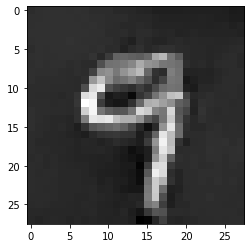

In [14]:
#Tạo một ảnh riêng lẻ
nb_of_images=1 #Số ảnh muốn tạo
label_to_generate=9
random_noise = generate_noise((nb_of_images, 100))
random_label = generate_condition_embedding(label_to_generate, nb_of_images)

generated_images = generator.predict([random_noise, random_label])

image = generated_images[0]
image = np.array(image, dtype = 'float')
pixels = image.reshape((28,28))
plt.imshow(pixels, cmap='gray')

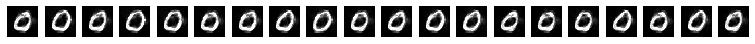

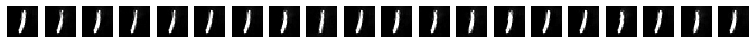

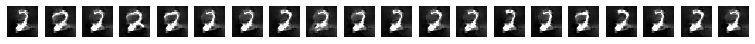

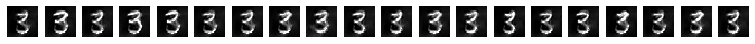

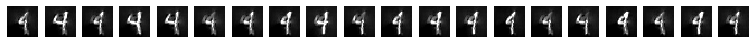

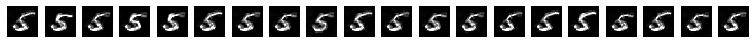

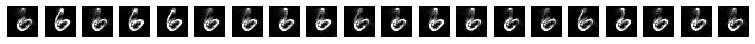

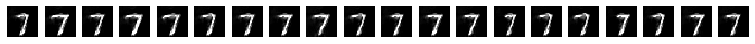

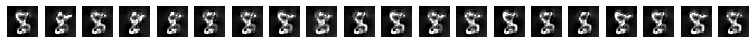

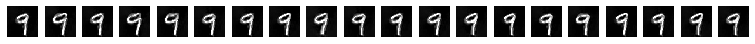

In [15]:
#Số lượng ảnh muốn tạo cho một label
nb_of_images=20

#Tạo một nhiễu bất kỳ (tương tự như seed)
random_noise = generate_noise((nb_of_images, 100))


for label_to_generate in range(10):
  #Tạo một vector one-hot-encoder (100,0) chứa label
  random_label = generate_condition_embedding(label_to_generate, nb_of_images)
  #Tạo ảnh từ Generator từ vector nhiễu và label 
  generated_images = generator.predict([random_noise, random_label])
  plt.figure(figsize=(20,10))
  for i in range(nb_of_images):
    
    #Chuyển thành ma trận kích thước 28 x 28 x1 
    image = generated_images[i]
    image = np.array(image, dtype = 'float')
    pixels = image.reshape((28,28))
    
    plt.subplot(15,30,i+1)
    plt.imshow(pixels, cmap='gray', vmin=-1.0, vmax=1.0)
    plt.axis('off')
    
  plt.show()
